In [1]:
include("MySimplexQuad.jl")
using .MySimplexQuad

include("OrthoPols.jl")
using .OrthoPols

use_bigfloat = false

###############################################################

function rse(vec::Vector{T}) where T
    threshold = if T == BigFloat
        BigFloat("1e-60")
    else
        T(1e-14)
    end
    
    map(x -> abs(x) < threshold ? zero(T) : x, vec)
end

###############################################################


function Trans(point::Vector{T}) where T
    @assert length(point) == 2 "Input point must be a 2-element vector"

    # Define the vertices of the target triangle
    v1 = T[-1, -1 / sqrt(T(3))]   # (0,0) maps to this
    v2 = T[ 1, -1 / sqrt(T(3))]   # (1,0) maps to this
    v3 = T[ 0,  2 / sqrt(T(3))]   # (0,1) maps to this
    
    # Extract x and y from the input point
    x, y = point

    # Compute the affine transformation
    new_x = (v2[1] - v1[1]) * x + (v3[1] - v1[1]) * y + v1[1]
    new_y = (v2[2] - v1[2]) * x + (v3[2] - v1[2]) * y + v1[2]

    return T[new_x, new_y]
end

function TransJ()
    # Determine the type based on the global variable
    T = use_bigfloat ? BigFloat : Float64

    # Define the vertices of the target triangle
    v1 = T[-1, -1 / sqrt(T(3))]
    v2 = T[ 1, -1 / sqrt(T(3))]
    v3 = T[ 0,  2 / sqrt(T(3))]
    
    # Compute the Jacobian matrix
    J = T[
        v2[1] - v1[1]  v3[1] - v1[1];
        v2[2] - v1[2]  v3[2] - v1[2]
    ]
    
    return J
end

function TransBack(point::Vector{T}) where T
    @assert length(point) == 2 "Input point must be a 2-element vector"

    # Define the vertices of the target triangle
    v1 = T[-1, -1 / sqrt(T(3))]   # Maps to (0,0)
    v2 = T[ 1, -1 / sqrt(T(3))]   # Maps to (1,0)
    v3 = T[ 0,  2 / sqrt(T(3))]   # Maps to (0,1)
    
    # Extract x and y from the input point
    x, y = point

    # Compute the inverse affine transformation
    denominator = (v1[1] * (v2[2] - v3[2]) + v2[1] * (v3[2] - v1[2]) + v3[1] * (v1[2] - v2[2]))
    
    new_x = ((v2[2] - v3[2]) * (x - v1[1]) + (v3[1] - v2[1]) * (y - v1[2])) / denominator
    new_y = ((v3[2] - v1[2]) * (x - v2[1]) + (v1[1] - v3[1]) * (y - v2[2])) / denominator

    return T[new_x, new_y]
end

function TransBackJ()
    # Determine the type based on the global variable
    T = use_bigfloat ? BigFloat : Float64

    # Define the vertices of the target triangle
    v1 = T[-1, -1 / sqrt(T(3))]   # Maps to (0,0)
    v2 = T[ 1, -1 / sqrt(T(3))]   # Maps to (1,0)
    v3 = T[ 0,  2 / sqrt(T(3))]   # Maps to (0,1)
    
    # Compute the denominator
    denominator = (v1[1] * (v2[2] - v3[2]) + v2[1] * (v3[2] - v1[2]) + v3[1] * (v1[2] - v2[2]))
    
    # Compute the Jacobian matrix
    J = T[(v2[2] - v3[2]) / denominator  (v3[1] - v2[1]) / denominator;
          (v3[2] - v1[2]) / denominator  (v1[1] - v3[1]) / denominator]
    
    return J
end

###############################################################

TransBackJ (generic function with 1 method)

In [2]:
using LinearAlgebra
using Optim
using Plots
using Optim
using LineSearches

freeparam = 7
order = 12

specs = [
    (1, 0), # Vertices
    # (2, 0), # Edge Midpoints
    # (3, 0), # Trig Midpoint
    (4, 1), # Edge class
    (4, 1), # Edge class
    (5, 1), # Interior class, type 1
    (5, 1), # Interior class, type 1
    (5, 1), # Interior class, type 1
    (6, 2)  # Interior class, type 2
]

# indices = [1,4,6,8,10,11,13,15]
indices = 1:(Int((order+1)*(order+2)/2))

###############################################################

function (vec::Vector{T}) where T <: AbstractFloat
    threshold = if T == BigFloat
        BigFloat("1e-60")
    else
        T(1e-14)
    end
    
    map(x -> abs(x) < threshold ? zero(T) : x, vec)
end

###############################################################
p1 = use_bigfloat ? BigFloat[0.0, 0.0] : [0.0, 0.0]
p2 = use_bigfloat ? BigFloat[1.0, 0.0] : [1.0, 0.0]
p3 = use_bigfloat ? BigFloat[0.0, 1.0] : [0.0, 1.0]

m1 = (p2 .+ p3) ./ (use_bigfloat ? BigFloat(2.0) : 2.0)
m2 = (p1 .+ p3) ./ (use_bigfloat ? BigFloat(2.0) : 2.0)
m3 = (p1 .+ p2) ./ (use_bigfloat ? BigFloat(2.0) : 2.0)

b = (p1 .+ p2 .+ p3) ./ (use_bigfloat ? BigFloat(3.0) : 3.0)
###############################################################


# vertices
T1 = hcat(p1, p2, p3)
eval_T1(order) = (ortho2eva3(order, Trans(T1[:,1]))[1])+
                 (ortho2eva3(order, Trans(T1[:,2]))[1])+
                 (ortho2eva3(order, Trans(T1[:,3]))[1])

# edge midpoints
T2 = hcat(m1, m2, m3)
eval_T2(order) = (ortho2eva3(order, Trans(T2[:,1]))[1])+
                 (ortho2eva3(order, Trans(T2[:,2]))[1])+
                 (ortho2eva3(order, Trans(T2[:,3]))[1])

# midpoint
T3 = hcat(b)
eval_T3(order) = (ortho2eva3(order, Trans(T3[:,1]))[1])


# edge class
T4(a) = hcat(a * p1 .+ (1 .- a) * p2,
             a * p2 .+ (1 .- a) * p1,
             a * p3 .+ (1 .- a) * p1,
             a * p1 .+ (1 .- a) * p3,
             a * p3 .+ (1 .- a) * p2,
             a * p2 .+ (1 .- a) * p3)

dT4 = hcat(p1.-p2,
           p2.-p1,
           p3.-p1,
           p1.-p3,
           p3.-p2,
           p2.-p3)

eval_T4(order,a) = (ortho2eva3(order, Trans(T4(a)[:,1]))[1])+
                   (ortho2eva3(order, Trans(T4(a)[:,2]))[1])+
                   (ortho2eva3(order, Trans(T4(a)[:,3]))[1])+
                   (ortho2eva3(order, Trans(T4(a)[:,4]))[1])+
                   (ortho2eva3(order, Trans(T4(a)[:,5]))[1])+
                   (ortho2eva3(order, Trans(T4(a)[:,6]))[1])

eval_dT4(order,a) = ([ortho2eva3(order, Trans(T4(a)[:,1]))[2], ortho2eva3(order, Trans(T4(a)[:,1]))[3]]'*TransJ()*(dT4[:,1])+
                     [ortho2eva3(order, Trans(T4(a)[:,1]))[2], ortho2eva3(order, Trans(T4(a)[:,1]))[3]]'*TransJ()*(dT4[:,1])+
                     [ortho2eva3(order, Trans(T4(a)[:,1]))[2], ortho2eva3(order, Trans(T4(a)[:,1]))[3]]'*TransJ()*(dT4[:,1])+
                     [ortho2eva3(order, Trans(T4(a)[:,1]))[2], ortho2eva3(order, Trans(T4(a)[:,1]))[3]]'*TransJ()*(dT4[:,1])+
                     [ortho2eva3(order, Trans(T4(a)[:,1]))[2], ortho2eva3(order, Trans(T4(a)[:,1]))[3]]'*TransJ()*(dT4[:,1])+
                     [ortho2eva3(order, Trans(T4(a)[:,1]))[2], ortho2eva3(order, Trans(T4(a)[:,1]))[3]]'*TransJ()*(dT4[:,1]))'

# inner class, type 1
T5(a) = hcat(a * m1 .+ (1 .- a) * p1,
             a * m2 .+ (1 .- a) * p2,
             a * m3 .+ (1 .- a) * p3)

dT5 = hcat(m1-p1,
           m2-p2,
           m3-p3)

eval_T5(order,a) = ortho2eva3(order, Trans(T5(a)[:,1]))[1]+
                   ortho2eva3(order, Trans(T5(a)[:,2]))[1]+
                   ortho2eva3(order, Trans(T5(a)[:,3]))[1]

eval_dT5(order,a) = ([ortho2eva3(order, Trans(T5(a)[:,1]))[2], ortho2eva3(order, Trans(T5(a)[:,1]))[3]]'*TransJ()*(dT5[:,1])+
                     [ortho2eva3(order, Trans(T5(a)[:,2]))[2], ortho2eva3(order, Trans(T5(a)[:,2]))[3]]'*TransJ()*(dT5[:,2])+
                     [ortho2eva3(order, Trans(T5(a)[:,3]))[2], ortho2eva3(order, Trans(T5(a)[:,3]))[3]]'*TransJ()*(dT5[:,3]))'


# inner class, type 2
T6(a, b) =  hcat(b * (a * m1 .+ (1 - a) .* p1) .+ (1 - b) * (a * m2 .+ (1 - a) .* p2),
                 b * (a * m1 .+ (1 - a) .* p1) .+ (1 - b) * (a * m3 .+ (1 - a) .* p3),
                 b * (a * m3 .+ (1 - a) .* p3) .+ (1 - b) * (a * m2 .+ (1 - a) .* p2),
                 b * (a * m2 .+ (1 - a) .* p2) .+ (1 - b) * (a * m1 .+ (1 - a) .* p1),
                 b * (a * m3 .+ (1 - a) .* p3) .+ (1 - b) * (a * m1 .+ (1 - a) .* p1),
                 b * (a * m2 .+ (1 - a) .* p2) .+ (1 - b) * (a * m3 .+ (1 - a) .* p3))

daT6(b) = hcat(b * (m1 - p1) + (1 - b) * (m2 - p2),
               b * (m1 - p1) + (1 - b) * (m3 - p3),
               b * (m3 - p3) + (1 - b) * (m2 - p2),
               b * (m2 - p2) + (1 - b) * (m1 - p1),
               b * (m3 - p3) + (1 - b) * (m1 - p1),
               b * (m2 - p2) + (1 - b) * (m3 - p3))

dbT6(a) = hcat((a * m1 + (1 - a) * p1) - (a * m2 + (1 - a) * p2),
               (a * m1 + (1 - a) * p1) - (a * m3 + (1 - a) * p3),
               (a * m3 + (1 - a) * p3) - (a * m2 + (1 - a) * p2),
               (a * m2 + (1 - a) * p2) - (a * m1 + (1 - a) * p1),
               (a * m3 + (1 - a) * p3) - (a * m1 + (1 - a) * p1),
               (a * m2 + (1 - a) * p2) - (a * m3 + (1 - a) * p3))

eval_T6(order,a,b) = ortho2eva3(order, Trans(T6(a, b)[:,1]))[1]+
                     ortho2eva3(order, Trans(T6(a, b)[:,2]))[1]+
                     ortho2eva3(order, Trans(T6(a, b)[:,3]))[1]+
                     ortho2eva3(order, Trans(T6(a, b)[:,4]))[1]+
                     ortho2eva3(order, Trans(T6(a, b)[:,5]))[1]+
                     ortho2eva3(order, Trans(T6(a, b)[:,6]))[1]

eval_daT6(order,a,b) = ([ortho2eva3(order, Trans(T6(a, b)[:,1]))[2], ortho2eva3(order, Trans(T6(a, b)[:,1]))[3]]'*TransJ()*(daT6(b)[:,1])+
                        [ortho2eva3(order, Trans(T6(a, b)[:,2]))[2], ortho2eva3(order, Trans(T6(a, b)[:,2]))[3]]'*TransJ()*(daT6(b)[:,2])+
                        [ortho2eva3(order, Trans(T6(a, b)[:,3]))[2], ortho2eva3(order, Trans(T6(a, b)[:,3]))[3]]'*TransJ()*(daT6(b)[:,3])+
                        [ortho2eva3(order, Trans(T6(a, b)[:,4]))[2], ortho2eva3(order, Trans(T6(a, b)[:,4]))[3]]'*TransJ()*(daT6(b)[:,4])+
                        [ortho2eva3(order, Trans(T6(a, b)[:,5]))[2], ortho2eva3(order, Trans(T6(a, b)[:,5]))[3]]'*TransJ()*(daT6(b)[:,5])+
                        [ortho2eva3(order, Trans(T6(a, b)[:,6]))[2], ortho2eva3(order, Trans(T6(a, b)[:,6]))[3]]'*TransJ()*(daT6(b)[:,6]))'

eval_dbT6(order,a,b) = ([ortho2eva3(order, Trans(T6(a, b)[:,1]))[2], ortho2eva3(order, Trans(T6(a, b)[:,1]))[3]]'*TransJ()*(dbT6(a)[:,1])+
                        [ortho2eva3(order, Trans(T6(a, b)[:,2]))[2], ortho2eva3(order, Trans(T6(a, b)[:,2]))[3]]'*TransJ()*(dbT6(a)[:,2])+
                        [ortho2eva3(order, Trans(T6(a, b)[:,3]))[2], ortho2eva3(order, Trans(T6(a, b)[:,3]))[3]]'*TransJ()*(dbT6(a)[:,3])+
                        [ortho2eva3(order, Trans(T6(a, b)[:,4]))[2], ortho2eva3(order, Trans(T6(a, b)[:,4]))[3]]'*TransJ()*(dbT6(a)[:,4])+
                        [ortho2eva3(order, Trans(T6(a, b)[:,5]))[2], ortho2eva3(order, Trans(T6(a, b)[:,5]))[3]]'*TransJ()*(dbT6(a)[:,5])+
                        [ortho2eva3(order, Trans(T6(a, b)[:,6]))[2], ortho2eva3(order, Trans(T6(a, b)[:,6]))[3]]'*TransJ()*(dbT6(a)[:,6]))'

##############################################################################################################################

function generate_A(specs)
    expr = quote
        function A(a)
            hcat(
                $(generate_exprs(specs)...)
            )
        end
    end
    return eval(expr)
end

function generate_exprs(specs)
    a_index = 1
    exprs = []
    for (T, param_count) in specs
        if param_count == 0
            push!(exprs, :(eval_T$T(order)[indices]))
        else
            params = [:(a[$i]) for i in a_index:(a_index+param_count-1)]
            push!(exprs, :(eval_T$T(order, $(params...))[indices]))
            a_index += param_count
        end
    end
    return exprs
end

# # Usage
# specs = [
#     (1, 0),
#     (2, 0),
#     (3, 0),
#     (4, 1),
#     (5, 1),
#     (6, 2)
# ]

# Anew = generate_A(specs)



##############################################################################################################################

function generate_A_and_dA(specs)
    A_expr = generate_A_expr(specs)
    dA_exprs = generate_dA_exprs(specs)
    combined_dA_expr = generate_combined_dA_expr(dA_exprs)
    
    return eval(quote
        $A_expr
        $(dA_exprs...)
        $combined_dA_expr
        (A = A, dA = dA)
    end)
end

function generate_A_expr(specs)
    quote
        function A(a)
            hcat($(generate_columns(specs, :eval_T)...))
        end
    end
end

function generate_dA_exprs(specs)
    param_count = sum(spec[2] for spec in specs)
    [generate_dA_expr(specs, i) for i in 1:param_count]
end

function generate_dA_expr(specs, param_index)
    columns = generate_columns(specs, :eval_T, param_index)
    quote
        function $(Symbol("dA$param_index"))(a)
            hcat($(columns...))
        end
    end
end

function generate_combined_dA_expr(dA_exprs)
    quote
        function dA(a)
            vcat($([:($(Symbol("dA$i"))(a)) for i in 1:length(dA_exprs)]...))
        end
    end
end

function generate_columns(specs, base_func, active_param=nothing)
    a_index = 1
    columns = []
    for (T, param_count) in specs
        if param_count == 0
            push!(columns, :($(Symbol("$(base_func)$T"))(order)[indices]))
        else
            params = [:(a[$i]) for i in a_index:(a_index+param_count-1)]
            if active_param !== nothing && a_index <= active_param < a_index + param_count
                if T == 6
                    func = active_param == a_index ? :eval_daT6 : :eval_dbT6
                else
                    func = Symbol("eval_dT$T")
                end
                push!(columns, :($func(order, $(params...))[indices]))
            else
                expr = :($(Symbol("$(base_func)$T"))(order, $(params...))[indices])
                expr = active_param === nothing ? expr : :(0 * $expr)
                push!(columns, expr)
            end
            a_index += param_count
        end
    end
    return columns
end

# Usage
# specs = [
#     (1, 0),
#     (2, 0),
#     (3, 0),
#     (4, 1),
#     (5, 1),
#     (6, 2)
# ]

functions = generate_A_and_dA(specs)

##############################################################################################################################

# System setup
# function A(a)
#     hcat(
#         eval_T1(order)[indices], # trig vertices
#         eval_T2(order)[indices], # edge midpoints
#         eval_T3(order)[indices], # trig midpoint

#         eval_T4(order,a[1])[indices], # edge class
#         # eval_T4(order,a[2])[indices], # edge class
        
#         eval_T5(order,a[2])[indices], # inner class, type 1
#         # eval_T5(order,a[3])[indices], # inner class, type 1
#         # eval_T5(order,a[5])[indices], # inner class, type 1

#         eval_T6(order,a[3],a[4])[indices],
#         # eval_T6(order,a[3],a[4])[indices],
#         # eval_T5(order,a[8])[indices],
#     )
# end

# function dA1(a)
#     hcat(
#         0*eval_T1(order)[indices],
#         0*eval_T2(order)[indices],
#         0*eval_T3(order)[indices],
#         eval_dT4(order,a[1])[indices],
#         0*eval_dT5(order,a[2])[indices],
#         0*eval_dbT6(order,a[3],a[4])[indices],
#     )
# end

# function dA2(a)
#     hcat(
#         0*eval_T1(order)[indices],
#         0*eval_T2(order)[indices],
#         0*eval_T3(order)[indices],
#         0*eval_dT4(order,a[1])[indices],
#         eval_dT5(order,a[2])[indices],
#         0*eval_dbT6(order,a[3],a[4])[indices],
#     )
# end
# function dA3(a)
#     hcat(
#         0*eval_T1(order)[indices],
#         0*eval_T2(order)[indices],
#         0*eval_T3(order)[indices],
#         0*eval_dT4(order,a[1])[indices],
#         0*eval_dT5(order,a[2])[indices],
#         eval_daT6(order,a[3],a[4])[indices],
#     )
# end
# function dA4(a)
#     hcat(
#         0*eval_T1(order)[indices],
#         0*eval_T2(order)[indices],
#         0*eval_T3(order)[indices],
#         0*eval_dT4(order,a[1])[indices],
#         0*eval_dT5(order,a[2])[indices],
#         eval_dbT6(order,a[3],a[4])[indices],
#     )
# end

function rhs()
    T = use_bigfloat ? BigFloat : Float64
    X, W = mysimplexquad(T, order, 2)
    w = zeros(T, div((order + 1) * (order + 2), 2))[indices]  # Initialize w with the correct type and size
    
    for k = 1:length(W)
        pols = (ortho2eva3(order, Trans(T.(X[k,:])))[1])[indices]
        w .+= 2*W[k] .* pols
    end
    return w
end

funs = generate_A_and_dA(specs)

A = funs.A
dA = funs.dA

f(a) = norm(A(a)*((A(a)' * A(a))\(A(a)' * rhs()))-rhs())
g(a) = A(a)*((A(a)' * A(a))\(A(a)' * rhs()))-rhs()

g (generic function with 1 method)

In [3]:
# a = 0.2#4/(7 + sqrt(BigFloat("13")))

# a = [0.1,0.31,0.15,0.12]


B(a) = A(a)'*A(a)
C(a) = inv(B(a))

# # The last term in J(a) is always zero, since dA(a)'*rhs() is zero!
# J11(a) = dA1(a)*C(a)*A(a)'*rhs() -A(a)*C(a)*(dA1(a)'*A(a)+A(a)'*dA1(a))*C(a)*A(a)'*rhs() +A(a)*C(a)*dA1(a)'*rhs()
# J22(a) = dA2(a)*C(a)*A(a)'*rhs() -A(a)*C(a)*(dA2(a)'*A(a)+A(a)'*dA2(a))*C(a)*A(a)'*rhs() +A(a)*C(a)*dA2(a)'*rhs()
# J33(a) = dA3(a)*C(a)*A(a)'*rhs() -A(a)*C(a)*(dA3(a)'*A(a)+A(a)'*dA3(a))*C(a)*A(a)'*rhs() +A(a)*C(a)*dA3(a)'*rhs()
# J44(a) = dA4(a)*C(a)*A(a)'*rhs() -A(a)*C(a)*(dA4(a)'*A(a)+A(a)'*dA4(a))*C(a)*A(a)'*rhs() +A(a)*C(a)*dA4(a)'*rhs()
# Jalt(a) = hcat(J11(a), J22(a), J33(a), J44(a))

# dA(a) = vcat(dA1(a),dA2(a),dA3(a),dA4(a))
J1(a) = reshape(dA(a)*C(a)*A(a)'*rhs(),:,freeparam)

# m(a) = vcat(dA1(a)'*A(a)+A(a)'*dA1(a),
#             dA2(a)'*A(a)+A(a)'*dA2(a),
#             dA3(a)'*A(a)+A(a)'*dA3(a),
#             dA4(a)'*A(a)+A(a)'*dA4(a))

function m_new(a)
    A_a = A(a)
    dA_a = dA(a)
    
    # Determine the number of blocks dynamically
    n_rows_A, n_cols_A = size(A_a)
    n_rows_dA, n_cols_dA = size(dA_a)
    n_blocks = n_rows_dA ÷ n_rows_A

    # Split dA_a into blocks
    dA_blocks = [dA_a[i:i+n_rows_A-1, :] for i in 1:n_rows_A:n_rows_dA]
    
    return vcat([dAi' * A_a + A_a' * dAi for dAi in dA_blocks]...)
end

J2(a) = -A(a)*C(a)*reshape(m_new(a)*C(a)*A(a)'*rhs(),:,freeparam)
J(a) = J1(a) + J2(a)

min_val = 0.2
max_val = 0.8
a = min_val .+ (max_val - min_val) .*(rand(freeparam))


up(a) = inv(J(a)'*J(a))*J(a)'

# up(a)

# display(J(a))
# display(norm(Jalt(a)-J(a)))

# g(a)

# display(size(A(a)))
# display(size(dA(a)))

# norm(m(a)-m_new(a))

# up(a)

up (generic function with 1 method)

In [4]:
# a = [0.3077456934940429656111, 0.237227334916236420,  0.85068024455122430]
# a = BigFloat.["0.6894807431364100579396918181180814433517535177968706938351552098259565706780567", "0.8507006310889774391442044803876179324818943043445105747053922691075143478651292", "0.2368362067571452850895786255825590085510715845462959305260082230192311735189575"]
using Printf


            
weight(a) = ((A(a)' * A(a))\(A(a)' * rhs()))

for k=1:500
    min_val = 0.01
    max_val = 0.99
    a = min_val .+ (max_val - min_val) .*(rand(freeparam))
    bad = false

    print("starting with a new config: ")
    print("f(a) is about $(@sprintf("%.3g", f(a))). ")
    for i=1:1000
        try
            res = up(a)*g(a)
            a = a-res

            # println("$(@sprintf("%.3g", f(a))). ", norm(res))
            if norm(res)<1e-20
                print(".. res looking good!.")
                bad = false
                break
            end

            # println(a)
            
            if any(x -> (x<0), weight(a)) && i>5
                bad = true
                print(".. neg lams.\n")
                break
            elseif norm(res)>2  && i>5
                print(".. res norm too big, breaking.\n")
                bad = true
                break
            elseif any(x-> (x>5), a)  && i>5
                print(".. big weights.\n")
                bad = true
                break
            end
        catch e
            bad = true
            print(".. nans... breaking\n")
            break
        end
    end

    if !bad
        print(".. found something promising...")
        weights = ((A(a)' * A(a))\(A(a)' * rhs()))
        

        if all(x -> (x>0), weights)
            print(" WEIGHTS POSITIVE! \n")
            break
        else
            print("..weights negative, continuing ..")
            print("f(a)=", f(a), "\n")
            # if abs(f(a))<1e-10
            #     break
            # end
        end
    end
end

In [11]:
a = BigFloat.(["0.1322645816327139853538882200436473589432092214523613042891785652912853424033825",
               "0.3632980741536860457055063361841810532259840590132217699041213906669667508848856",
               "0.5137182145239181521277816629644033613478889432665964983204021026648219094966786",
               "0.115055368822820211321635035530863800881213087497156161764637485204809166321383",
               "0.9156736761583222038770064348481366069448359711167989051103586524373708347553003",
               "0.1563851672510340439977719569396516562552840409095293866190088949247856013241157",
               "0.8134250274303948218471218265542466604673601990058271109937427943875009474310373"])

println(a)

for i=1:1
    r = up(a)*g(a)
    a = a-r
    res = norm(r)

    # println(res)
    println(a)
    println("\n")
    if res<1e-90
        break
    end
end

print(a)

BigFloat[0.1322645816327139853538882200436473589432092214523613042891785652912853424033825, 0.3632980741536860457055063361841810532259840590132217699041213906669667508848856, 0.5137182145239181521277816629644033613478889432665964983204021026648219094966786, 0.115055368822820211321635035530863800881213087497156161764637485204809166321383, 0.9156736761583222038770064348481366069448359711167989051103586524373708347553003, 0.1563851672510340439977719569396516562552840409095293866190088949247856013241157, 0.8134250274303948218471218265542466604673601990058271109937427943875009474310373]
BigFloat[0.1322645816327139853538882200436473589432092214523613042891785652912853424033803, 0.3632980741536860457055063361841810532259840590132217699041213906669667508848856, 0.5137182145239181521277816629644033613478889432665964983204021026648219094966786, 0.1150553688228202113216350355308638008812130874971561617646374852048091663213917, 0.91567367615832220387700643484813660694483597111679890511035865243737

In [16]:
# up(a)
a
# f(a)
cond(J(a)'*J(a))

6.574880337799903274883897377823384084121509767651298726958653159832626281964015

In [17]:
weights = ((A(a)' * A(a))\(A(a)' * rhs()))
display(a)
display(weights)
display(f(a))

7-element Vector{BigFloat}:
 0.1322645816327139853538882200436473589432092214523613042891785652912853424033803
 0.3632980741536860457055063361841810532259840590132217699041213906669667508848856
 0.5137182145239181521277816629644033613478889432665964983204021026648219094966786
 0.1150553688228202113216350355308638008812130874971561617646374852048091663213917
 0.9156736761583222038770064348481366069448359711167989051103586524373708347553003
 0.1563851672510340439977719569396516562552840409095293866190088949247856013241178
 0.8134250274303948218471218265542466604673601990058271109937427943875009474310373

7-element Vector{BigFloat}:
 0.001418847941358491958592013142167566903682148988971710136422112013587925419978329
 0.006961157280978421316885355053306606626783891597959970413302537931065539947049369
 0.01238113000735325822823625385145974077706964686367593943723021215268559728443002
 0.09180247526152571475403829582713371371109543840295477271746227663231882926599472
 0.02325227091923514227899684743112030085978283029949638736272773817942823282606056
 0.06906086075456558705677702806082523413852311846006436821922925934139359291874778
 0.05455715193999251909734296553127691145627136012928713759821322349955123921978794

4.261635581837148467342150598618866770953244942809457838233472477489007649018701e-76

In [11]:
specs

7-element Vector{Tuple{Int64, Int64}}:
 (1, 0)
 (4, 1)
 (4, 1)
 (5, 1)
 (5, 1)
 (5, 1)
 (6, 2)

7-element Vector{BigFloat}:
 0.1322645816327139853538882200436473589432092214523613042891785652912853424033803
 0.3632980741536860457055063361841810532259840590132217699041213906669667508848856
 0.5137182145239181521277816629644033613478889432665964983204021026648219094966786
 0.1150553688228202113216350355308638008812130874971561617646374852048091663213917
 0.9156736761583222038770064348481366069448359711167989051103586524373708347553003
 0.1563851672510340439977719569396516562552840409095293866190088949247856013241178
 0.8134250274303948218471218265542466604673601990058271109937427943875009474310373

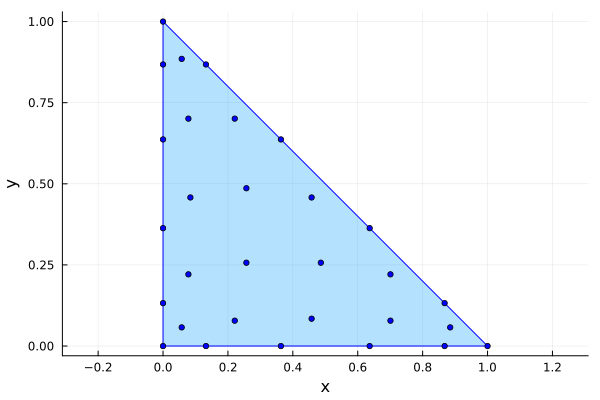

In [18]:
using Plots
# gr()  # Set the backend to GR
plot()
# Define the vertices of the triangle
x = [p1[1], p2[1], p3[1], p1[1]]
y = [p1[2], p2[2], p3[2], p1[2]]



# eval_T1(order), # trig vertices
# # eval_T2(order), # edge midpoints

# eval_T4(order,a[1]), # edge class
# eval_T4(order,a[2]), # edge class

# eval_T5(order,a[3]),
# eval_T5(order,a[4]),
# eval_T5(order,a[5]),

# eval_T3(order), # trig midpoint

# eval_T6(order,a[6],a[7]),
# # eval_T5(order,a[8]),

display(a)



# Plot the triangle
plot!(x, y, seriestype = :shape, fillalpha = 0.3, linecolor = :blue, legend = false, aspect_ratio = :equal)

scatter!(T1[1, :], T1[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)
# scatter!(T2[1, :], T2[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)
# scatter!(T3[1, :], T3[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)

scatter!(T4(a[1])[1, :], T4(a[1])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)
scatter!(T4(a[2])[1, :], T4(a[2])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)

scatter!(T5(a[3])[1, :], T5(a[3])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)
scatter!(T5(a[4])[1, :], T5(a[4])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)
scatter!(T5(a[5])[1, :], T5(a[5])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)

scatter!(T6(a[6],a[7])[1, :], T6(a[6],a[7])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)

# scatter!(T5(a[8])[1, :], T5(a[8])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)

# Add plot title and labels
xlabel!("x")
ylabel!("y")

# savefig("kek.png")

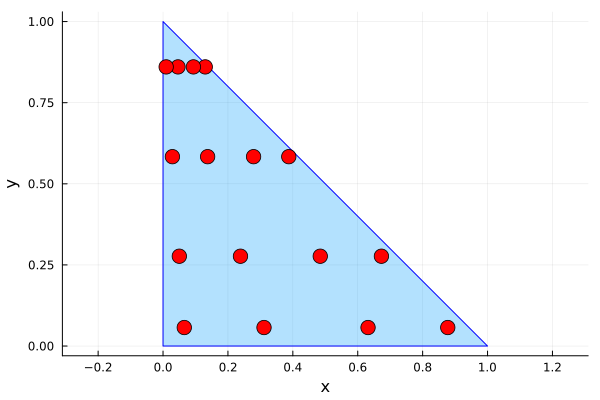

In [13]:
vertices = [
    0.0 0.0
    1.0 0.0
    0.0 1.0
]

# Need at least 4 vertices for plotting?
vertices1 = [vertices; vertices[1:1, :]]

using Plots
plot()

# for npoints in [1,2]
npoints = 4
    X, W = mysimplexquad(BigFloat, npoints, 2)

    # Plot the triangle
    plot!(vertices1'[1,:], vertices1'[2,:], seriestype = :shape, fillalpha = 0.3, linecolor = :blue, legend = false, aspect_ratio = :equal)
    scatter!(X[:, 1], X[:, 2], markersize = 8, markercolor = :red, legend = false, aspect_ratio = :equal)

    # Add plot title and labels
    xlabel!("x")
    ylabel!("y")
# end